# Section 4: Human-in-the-Loop with LangGraph Primitives

In Section 3, we built a supervisor using `create_agent` that routes queries to specialized sub-agents. However, for some queries like _"Whats the status of my recent order?"_, we need to first verify the customer's identity before the agent can provide support.

<div align="center">
    <img src="../../static/supervisor_with_verification.png">
</div>

In this section, we'll add a **verification layer** to our agent using LangGraph primitives that:
- Classifies whether a query needs identity verification
- Pauses execution to collect customer email (HITL)
- Validates the email against our customer database
- Retries up to 3 times if email isn't found
- Skips verification on follow-up questions in the same thread
- Routes to our Supervisor Agent for the actual query handling

We keep the sub-agents simple (`create_agent`), but add more complex orchestration with LangGraph.

## 1. Setup

Load environment variables and necessary imports.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## 2. Build Verification Layer with LangGraph Primitives

Now we'll add a verification layer that sits **in front of** the supervisor. This layer:
- Checks if verification is needed
- Interrupts to collect customer email
- Validates against database
- Retries if email not found
- Skips verification on follow-ups


### State Schema

Since we'll now be collecting and storing information about the customer, we need to make sure this information is persisted in our graph's state. 

**Key Architectural Decision:** We'll extend `AgentState` from LangChain, which gives us:
- Built-in `messages` key with proper reducers
- Compatibility with `create_agent` subgraphs
- **Shared state keys** that automatically flow to the supervisor and sub-agents

By using a shared state schema across all graphs, the `customer_id` will be accessible:
- In the verification layer (for checking if already verified)
- In the supervisor agent (passed through automatically)
- In the sub-agents (accessible via `ToolRuntime` in tools)

We'll add these additional state keys:
1. `customer_id` - Set after successful verification, used by tools
2. `verification_attempts` - Counter for retry loop

In [32]:
from langchain.agents import AgentState


class CustomState(AgentState):
    """Shared state extending AgentState.

    This state is used by:
    - Verification graph (parent)
    - Supervisor agent (subgraph)
    - Database and Documents agents (sub-subgraphs)

    Shared keys automatically flow between parent and subgraphs.
    """

    # messages inherited from AgentState with proper reducers
    customer_id: str
    verification_attempts: int

### Define Graph Nodes

We'll create 4 nodes:
1. **query_router**: Routes based on verification needs (checks state + classifies query intent)
2. **verify_customer**: Uses LLM to conversationally collect & validate user's email
3. **collect_email**: Dedicated HITL node that pauses with `interrupt()` to collect user input
4. **supervisor_agent (subgraph)**: The supervisor agent that handles the actual query

### Node 1: Query Router

The "Query Router" node makes a decision about whether identity verification is required to answer the user's question.

It inspects the agent's state and the user's latest message to determine:
1. if the customer should be prompted for verification (such as when asking for information about a particular order), or 
2. if the request can proceed directly to the supervisor agent (for general questions or public information).


#### Helpers
We'll use an LLM with structured output to classify each user message to determine if it requires verification, so lets set that up first:

In [3]:
import pprint
from typing_extensions import TypedDict, Annotated
from langchain.chat_models import init_chat_model


# TypedDict for structured LLM output
class QueryClassification(TypedDict):
    """Classification of whether customer identity verification is required."""

    reasoning: Annotated[
        str, ..., "Brief explanation of why verification is or isn't needed"
    ]
    requires_verification: Annotated[
        bool,
        ...,
        "True if the query requires knowing customer identity (e.g., 'my orders', 'my account', 'my purchases'). False for general questions (product info, policies, how-to questions).",
    ]


def classify_query_intent(query: str) -> QueryClassification:
    """Classify whether a query requires customer identity verification.

    Args:
        query: The user's query string

    Returns:
        QueryClassification dict with reasoning and requires_verification fields
    """
    llm = init_chat_model("anthropic:claude-haiku-4-5")

    # Create structured LLM
    structured_llm = llm.with_structured_output(QueryClassification)
    classification_prompt = """Analyze the user's query to determine if it requires knowing their customer identity in order to answer the question."""

    # Get structured classification
    classification = structured_llm.invoke(
        [
            {"role": "system", "content": classification_prompt},
            {"role": "user", "content": "Query: " + query},
        ]
    )

    return classification

In [4]:
test = classify_query_intent("Whats the status of my recent order?")
pprint.pprint(test)

{'reasoning': 'This query asks about "my recent order," which is personal '
              'account information specific to the customer. To answer this '
              "question, we would need to know the customer's identity and "
              'retrieve their order history and status. This requires customer '
              'identity verification.',
 'requires_verification': True}


#### Query Router Node

Now we can leverage this `classify_query_intent` function in a node to intelligently decide when to route users to identity verification versus letting them skip directly to the supervisor agent for general questions.

In [5]:
from langgraph.types import Command
from typing import Literal


# Node 1: Query Router
def query_router(
    state: CustomState,
) -> Command[Literal["verify_customer", "supervisor_agent"]]:
    """Route based on verification needs.

    Logic:
    1. If customer already verified from earlier in the thread → supervisor_agent
    2. If query needs verification → verify_customer
    3. Otherwise → supervisor_agent
    """

    # Already verified? Skip to supervisor agent
    if state.get("customer_id"):
        return Command(goto="supervisor_agent")

    # Not already verified - classify query to see if verification is needed
    last_message = state["messages"][-1]
    intent_classification = classify_query_intent(last_message.content)

    # Route based on classification
    if intent_classification.get("requires_verification"):
        return Command(goto="verify_customer")
    return Command(goto="supervisor_agent")

### Node 2: Verify Customer

The "Verify Customer" node is responsible for conversationally collecting and validating the customer's email address.

This node:
- Uses an LLM to naturally converse with the customer
- Extracts email from user messages using structured output
- Validates the email against our customer database
- Generates helpful, context-aware error messages if the email isn't found
- Adds all messages to the conversation history

#### Helpers

To verify customers, we need a few helper functions for:
1. **Email extraction** - Use LLM with structured output to extract email from natural language interaction
2. **Email validation** - Check email's format and confirm it exists in database
3. **Conversational responses** - Generate natural prompts and error messages

In [6]:
import sqlite3
from pathlib import Path
from typing import NamedTuple
from typing_extensions import TypedDict, Annotated
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage

DB_PATH = Path("../../data/structured/techhub.db")


# 1. Email Extraction Schema
class EmailExtraction(TypedDict):
    """Schema for extracting email from user message."""

    email: Annotated[
        str,
        ...,
        "The email address extracted from the message, or empty string if none found",
    ]


# 2. Customer Info Schema
class CustomerInfo(NamedTuple):
    """Customer information returned from validation."""

    customer_id: str
    customer_name: str


# 3. Email Extractor (LLM with structured output)
def create_email_extractor():
    """Create an LLM configured to extract emails from natural language."""
    llm = init_chat_model("anthropic:claude-haiku-4-5")
    return llm.with_structured_output(EmailExtraction)


# 4. Verification LLM (for conversational prompts)
def create_verification_llm():
    """Create an LLM for conversational verification responses."""
    return init_chat_model("anthropic:claude-haiku-4-5")


# 5. System Prompt for Verification
VERIFICATION_SYSTEM_PROMPT = """You are a friendly identity verification assistant for TechHub.

Your job: Collect the customer's email address to verify their identity.
- Politely ask for their email if not yet provided
- Extract email from natural language responses ("My email is sarah@..." or just "sarah@...")  
- If they provide an invalid email, ask them to double-check
- Be helpful and conversational

IMPORTANT: Only focus on collecting their email. Don't try to help with their actual request until verified."""


# 6. Email Validator (format check + database lookup)
def validate_customer_email(email: str) -> CustomerInfo | None:
    """Validate email format and lookup customer in database.

    Args:
        email: Email address to validate

    Returns:
        CustomerInfo with customer_id and customer_name if valid, None otherwise
    """
    # Check email format
    if not email or "@" not in email:
        return None

    # Lookup in database
    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()
    cursor.execute("SELECT customer_id, name FROM customers WHERE email = ?", (email,))
    result = cursor.fetchone()
    conn.close()

    if not result:
        return None

    return CustomerInfo(customer_id=result[0], customer_name=result[1])

#### Verify Customer Node

Now we can use these helpers in our `verify_customer` node. The node will:
1. Check if customer already verified (pass through if so)
2. Extract email from the user's last message using structured output
3. If email found → validate against database → return success or error
4. If no email found → ask the user to provide it


In [7]:
# Node 2: Verify Customer
def verify_customer(state: CustomState):
    """Verify customer identity using conversational email collection.

    This node:
    - Uses an LLM to naturally converse with the customer
    - Extracts email from natural language responses
    - Validates email against database
    - Generates helpful error messages if email not found
    - Adds all messages to conversation history
    """

    # If already verified, pass through (conditional edge will route)
    if state.get("customer_id"):
        pass

    # Get last message from user
    last_message = state["messages"][-1]

    # Try to extract email using structured output
    email_extractor = create_email_extractor()
    extraction = email_extractor.invoke(
        [
            SystemMessage(
                content="Extract the email address from the user's message. If no email is present, return empty string."
            ),
            last_message,
        ]
    )

    # If we got an email, validate it
    if extraction["email"]:
        customer = validate_customer_email(extraction["email"])

        if customer:
            # Success! Email verified
            confirmation = AIMessage(
                content=f"Thank you! I've verified your account with customer id: {customer.customer_id}. Let me help you now."
            )
            return {"customer_id": customer.customer_id, "messages": [confirmation]}
        else:
            # Email not found in database - LLM generates helpful response
            verification_llm = create_verification_llm()
            error_context = SystemMessage(
                content=f"{VERIFICATION_SYSTEM_PROMPT}\n\nThe email '{extraction['email']}' was not found in our system. Please ask them to double-check or provide a different email."
            )
            response = verification_llm.invoke([error_context] + state["messages"])
            return {"messages": [response]}

    # No email extracted - LLM asks for email
    verification_llm = create_verification_llm()
    response = verification_llm.invoke(
        [SystemMessage(content=VERIFICATION_SYSTEM_PROMPT), *state["messages"]]
    )
    return {"messages": [response]}

### Node 3: Collect Email (Human Input)

The "Collect Email" node is our dedicated node for collecting the human input.

By separating HITL into its own node, we get:
- **Clear graph visualization** - The interrupt point is explicit in the graph
- **Clean separation of concerns** - Business logic (verify_customer) separate from input collection
- **Full message history** - All messages automatically saved to state


#### Collect Email Node

The node simply:
1. Calls `interrupt()` to pause execution
2. Waits for user to provide input via `Command(resume=...)`
3. Returns the input as a `HumanMessage`


In [8]:
from langgraph.types import interrupt


# Node 3: Collect Email (HITL)
def collect_email(state: CustomState):
    """Dedicated node for collecting human input via interrupt."""
    user_input = interrupt("Please provide your email:")
    return {"messages": [HumanMessage(content=user_input)]}

### Node 4: Conditional Edge

A "conditional edge" is a routing function that determines which node to execute next based on the current state.

For our verification loop, we need to route based on whether the customer has been successfully verified:
- If `customer_id` exists in state → verification succeeded → route to `supervisor_agent`
- If `customer_id` doesn't exist → need more input → route to `collect_email` (HITL)


#### Conditional Edge Function

The function returns a string indicating which node to route to next.


In [29]:
from typing import Literal


# Conditional edge routing function
def should_continue_verification(
    state: CustomState,
) -> Literal["collect_email", "supervisor_agent"]:
    """Route based on verification status.

    Logic:
    - If customer_id exists → verification succeeded → route to supervisor_agent
    - Otherwise → need more input → route to collect_email (HITL)
    """
    if state.get("customer_id"):
        return "customer_verified"
    return "interrupt_needed"

### Node 5: Supervisor Agent (Subgraph)

The "Supervisor Agent" is the final node in our verification graph. It's actually a **subgraph** - a complete compiled graph from Section 3 that we're reusing as a node!

We've refactored ALL agents from Section 3 (Database, Documents, and Supervisor) into the `agents/` directory as factory functions. This demonstrates:
- **Code reuse** - Don't duplicate code across notebooks
- **Clean separation** - Verification layer separate from query handling
- **Composability** - Graphs can be composed as nodes in other graphs


#### Supervisor Agent Node

We instantiate the supervisor agent using the factory function, which internally creates and wires together the sub-agents.

**Key Implementation Detail:** We pass `CustomState` to all agent factory functions. This creates a shared state schema across the entire graph hierarchy:
- Verification graph (parent) ↔ Supervisor (subgraph) ↔ Sub-agents (sub-subgraphs)
- All shared keys (`messages`, `customer_id`) automatically flow between levels
- Tools can access `customer_id` via `ToolRuntime` when needed

We'll add it directly to [our graph as a node](https://docs.langchain.com/oss/python/langgraph/use-subgraphs#add-a-graph-as-a-node).

#### Introducing State-Dependent Tools with ToolRuntime

Up to this point (Sections 1-3), all our database tools were **stateless** - they required explicit parameters like `order_id` or `product_name`. But now that we have customer verification with `customer_id` stored in state, we can introduce **state-dependent tools** that automatically access shared state!

**New Tool: `get_customer_orders`**

This tool uses the `ToolRuntime` pattern to access `customer_id` from the agent's state:

```python
@tool
def get_customer_orders(runtime: ToolRuntime) -> str:
    """Get recent orders for the verified customer."""
    customer_id = runtime.state.get("customer_id")
    # ... query database with customer_id
```


In [11]:
from agents import create_db_agent, create_docs_agent, create_supervisor_agent
from tools import get_customer_orders

# Instantiate sub-agents with shared state schema AND state-dependent tools
# The db_agent gets get_customer_orders, which uses ToolRuntime to access customer_id
db_agent = create_db_agent(
    state_schema=CustomState, additional_tools=[get_customer_orders]
)
docs_agent = create_docs_agent()

# Instantiate supervisor agent (which wraps the sub-agents as tools)
supervisor_agent = create_supervisor_agent(
    db_agent, docs_agent, state_schema=CustomState
)

print("✓ Agents instantiated with:")
print("  • Shared CustomState schema (customer_id flows across all agents)")
print("  • DB Agent has access to get_customer_orders (ToolRuntime pattern)")
print("  • All agents can access verified customer_id from state")

✓ Agents instantiated with:
  • Shared CustomState schema (customer_id flows across all agents)
  • DB Agent has access to get_customer_orders (ToolRuntime pattern)
  • All agents can access verified customer_id from state


### Build and Compile the Verification Graph

Now we wire everything together:
- Add all nodes (including supervisor agent as a subgraph node)
- Set entry point
- Add conditional edge for HITL verification
- Compile with checkpointer (REQUIRED for interrupt())

In [30]:
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# Build the verification graph
workflow = StateGraph(CustomState)

# Add nodes
workflow.add_node("query_router", query_router)
workflow.add_node("verify_customer", verify_customer)
workflow.add_node("collect_email", collect_email)  # HITL node
workflow.add_node("supervisor_agent", supervisor_agent)

# Set entry point
workflow.add_edge(START, "query_router")

# Add edges
# After verify_customer, use conditional edge to route based on verification status
workflow.add_conditional_edges(
    source="verify_customer",
    path=should_continue_verification,
    path_map={
        "interrupt_needed": "collect_email",  # Need more input → HITL
        "customer_verified": "supervisor_agent",  # Verified → proceed
    },
)

# After collecting email, route back to verify_customer for validation
workflow.add_edge("collect_email", "verify_customer")

# Compile with checkpointer (REQUIRED for interrupt)
verification_graph = workflow.compile(checkpointer=MemorySaver())

### Visualize the Graph

Let's see what we built:

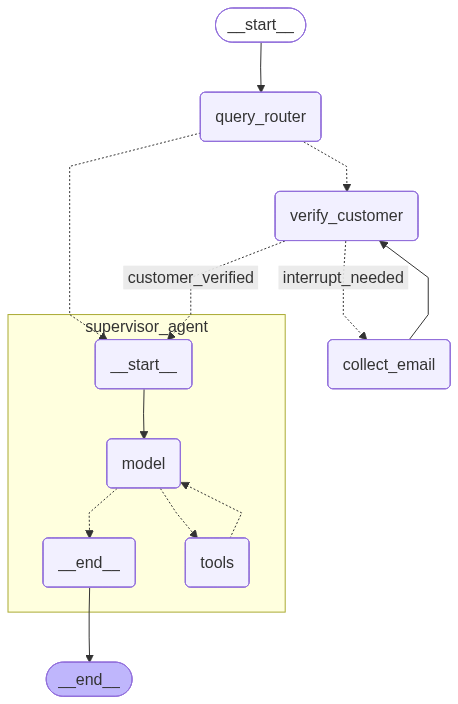

In [31]:
from IPython.display import Image

display(Image(verification_graph.get_graph(xray=True).draw_mermaid_png()))

## 4. Test the Verification Graph

Let's test all four scenarios:
1. **General query** - No verification needed
2. **Personal query** - Verification with successful email
3. **Personal query with retry** - Invalid email, then valid email
4. **Follow-up query** - Verification skipped (already verified in thread)

### Scenario 1: General Query (No HITL)

Queries about products or policies don't need customer identity verification.

In [14]:
import uuid

# New thread for this scenario
thread_id_1 = str(uuid.uuid4())
config_1 = {"configurable": {"thread_id": thread_id_1}}

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Hi")]}, config=config_1
)

In [15]:
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='3e723580-b55b-4a5f-acde-803625116594'),
  AIMessage(content="Hello! 👋 Welcome to TechHub customer support. I'm here to help you with any questions or concerns you may have.\n\nHow can I assist you today? Whether it's about:\n- **Order status** or tracking\n- **Product information** or specs\n- **Pricing** or billing questions\n- **Policies** or warranties\n- **Setup instructions** or technical help\n\nFeel free to let me know what you need, and I'll make sure to get you the right support!", additional_kwargs={}, response_metadata={'id': 'msg_01Mxr3t2hfRBCrdpwqqLF7YR', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 744, 'output_tokens': 110, 'server_tool_use': None, 'service_tier': 'stand

In [16]:
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="how much was my last order?")]}, config=config_1
)
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='3e723580-b55b-4a5f-acde-803625116594'),
  AIMessage(content="Hello! 👋 Welcome to TechHub customer support. I'm here to help you with any questions or concerns you may have.\n\nHow can I assist you today? Whether it's about:\n- **Order status** or tracking\n- **Product information** or specs\n- **Pricing** or billing questions\n- **Policies** or warranties\n- **Setup instructions** or technical help\n\nFeel free to let me know what you need, and I'll make sure to get you the right support!", additional_kwargs={}, response_metadata={'id': 'msg_01Mxr3t2hfRBCrdpwqqLF7YR', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 744, 'output_tokens': 110, 'server_tool_use': None, 'service_tier': 'stand

In [17]:
result = verification_graph.invoke(
    Command(resume="Yes, sure thing, its:  sarah.chen@gmail.com"), config=config_1
)

In [18]:
result

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='3e723580-b55b-4a5f-acde-803625116594'),
  AIMessage(content="Hello! 👋 Welcome to TechHub customer support. I'm here to help you with any questions or concerns you may have.\n\nHow can I assist you today? Whether it's about:\n- **Order status** or tracking\n- **Product information** or specs\n- **Pricing** or billing questions\n- **Policies** or warranties\n- **Setup instructions** or technical help\n\nFeel free to let me know what you need, and I'll make sure to get you the right support!", additional_kwargs={}, response_metadata={'id': 'msg_01Mxr3t2hfRBCrdpwqqLF7YR', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 744, 'output_tokens': 110, 'server_tool_use': None, 'service_tier': 'stand

In [19]:
import uuid
from langchain_core.messages import HumanMessage

# New thread for this scenario
thread_id_1 = str(uuid.uuid4())
config_1 = {"configurable": {"thread_id": thread_id_1}}

print("Query: 'What's your return policy?'")
print("=" * 70)

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="What's your return policy?")]}, config=config_1
)

# Print final response
print("\nResponse:")
print(result["messages"][-1].content[:200] + "...")

print("\n💡 Flow: query_router (classifies as NO) → supervisor_agent → END")
print("   No HITL needed for general questions!")

Query: 'What's your return policy?'

Response:
Here's TechHub's return policy:

**Return Windows:**
- **Unopened Electronics**: 30 days from delivery (full refund if original packaging and seals are intact)
- **Opened Electronics**: 14 days from d...

💡 Flow: query_router (classifies as NO) → supervisor_agent → END
   No HITL needed for general questions!


### Scenario 2: Personal Query with Successful Verification

Queries about "my orders" require identity verification.

**Test email:** `sarah.chen@gmail.com` (exists in database)

In [20]:
# New thread
thread_id_2 = str(uuid.uuid4())
config_2 = {"configurable": {"thread_id": thread_id_2}}

print("Query: 'Whats the status of my recent order?'")
print("=" * 70)

# First invocation - will pause at interrupt
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Whats the status of my recent order?")]},
    config=config_2,
)

print("\n⏸️  Graph PAUSED at interrupt()")
print(
    "Interrupt prompt:",
    (
        result.get("__interrupt__", [{}])[0].value
        if result.get("__interrupt__")
        else "N/A"
    ),
)
print(
    "\n💡 Flow so far: query_router → verify_customer (LLM asks for email) → collect_email (INTERRUPT)"
)
print("\nConversation so far:")
for msg in result["messages"]:
    print(f"  {msg.__class__.__name__}: {msg.content[:80]}...")

Query: 'Whats the status of my recent order?'

⏸️  Graph PAUSED at interrupt()
Interrupt prompt: Please provide your email:

💡 Flow so far: query_router → verify_customer (LLM asks for email) → collect_email (INTERRUPT)

Conversation so far:
  HumanMessage: Whats the status of my recent order?...
  AIMessage: Hi there! Thanks for reaching out to TechHub! 😊

I'd be happy to help you check ...


In [22]:
# Resume with valid email
result = verification_graph.invoke(
    Command(resume="sarah.chen@gmail.com"), config=config_2
)

print("\n✓ Verification successful!")
print("\nFull conversation:")
print("=" * 70)
for msg in result["messages"]:
    msg.pretty_print()

print("\n💡 Complete flow:")
print("   1. query_router → verify_customer (asks for email)")
print("   2. verify_customer → collect_email (INTERRUPT)")
print("   3. RESUME → verify_customer (extracts & validates email)")
print("   4. verify_customer → supervisor_agent → END")
print(f"\n   Customer ID verified: {result.get('customer_id')}")


✓ Verification successful!

Full conversation:
================================ Human Message =================================

Whats the status of my recent order?
================================== Ai Message ==================================

Hi there! Thanks for reaching out to TechHub! 😊

I'd be happy to help you check on your recent order, but first I need to verify your identity. Could you please provide me with the **email address** associated with your account?
================================ Human Message =================================

sarah.chen@gmail.com
================================== Ai Message ==================================

Thank you! I've verified your account with customer id: CUST-001. Let me help you now.
================================== Ai Message ==================================

[{'id': 'toolu_014YAWtiFtwqbHQqmfF4NJEw', 'input': {'query': 'customer_id CUST-001 recent orders status'}, 'name': 'database_specialist', 'type': 'tool_use'}]
Tool Call

In [23]:
result["messages"]

[HumanMessage(content='Whats the status of my recent order?', additional_kwargs={}, response_metadata={}, id='1d8fdfde-5de6-42e8-8344-6b21f0ded27d'),
 AIMessage(content="Hi there! Thanks for reaching out to TechHub! 😊\n\nI'd be happy to help you check on your recent order, but first I need to verify your identity. Could you please provide me with the **email address** associated with your account?", additional_kwargs={}, response_metadata={'id': 'msg_01HjKhoSiPxqvY1UnZRE1k9A', 'model': 'claude-haiku-4-5-20251001', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 125, 'output_tokens': 57, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-haiku-4-5-20251001', 'model_provider': 'anthropic'}, id='lc_run--da6e6788-7760-4944-bdca-4530952076eb-0', usage_metadata={'input_tokens': 125, 'output_tok

### Scenario 3: Personal Query with Retry (Invalid Email)

What happens when the user provides an invalid email? The graph retries!

In [24]:
# New thread
thread_id_3 = str(uuid.uuid4())
config_3 = {"configurable": {"thread_id": thread_id_3}}

print("Query: 'Show me my recent purchases'")
print("=" * 70)

# First invocation - pauses
result = verification_graph.invoke(
    {"messages": [HumanMessage(content="Show me my recent purchases")]}, config=config_3
)

print("\n⏸️  ATTEMPT 1: Graph paused at collect_email")
print(
    "Interrupt value:",
    (
        result.get("__interrupt__", [{}])[0].value
        if result.get("__interrupt__")
        else "N/A"
    ),
)
print("\nLast AI message:")
print(result["messages"][-1].content[:150] + "...")

Query: 'Show me my recent purchases'

⏸️  ATTEMPT 1: Graph paused at collect_email
Interrupt value: Please provide your email:

Last AI message:
Hello! I'd be happy to help you check your recent purchases. 

However, before I can access your account information, I need to verify your identity f...


In [25]:
# Resume with INVALID email (not in database)
result = verification_graph.invoke(Command(resume="wrong@email.com"), config=config_3)

print("\n⏸️  ATTEMPT 2: Email not found - graph paused again")
print(
    "Interrupt value:",
    (
        result.get("__interrupt__", [{}])[0].value
        if result.get("__interrupt__")
        else "N/A"
    ),
)
print("\nLLM generated error message (asking user to double-check):")
print(result["messages"][-1].content[:200] + "...")
print("\n💡 Flow: verify_customer (email not found) → collect_email (INTERRUPT again)")


⏸️  ATTEMPT 2: Email not found - graph paused again
Interrupt value: Please provide your email:

LLM generated error message (asking user to double-check):
Thank you for providing that email address. Unfortunately, **wrong@email.com** was not found in our system.

Could you please double-check the email address? Here are a few things to verify:
- Is it s...

💡 Flow: verify_customer (email not found) → collect_email (INTERRUPT again)


In [27]:
# Resume with VALID email
result = verification_graph.invoke(
    Command(resume="sarah.chen@gmail.com"), config=config_3
)

print("\n✓ Verification successful on second attempt!")
print("\nFinal response:")
print(result["messages"][-1].content[:200] + "...")

print("\n💡 Retry loop in action!")
print("   Attempt 1: wrong@email.com → error message → collect_email (INTERRUPT)")
print("   Attempt 2: sarah.chen@gmail.com → verified → supervisor_agent")
print(f"\n   Customer ID: {result.get('customer_id')}")


✓ Verification successful on second attempt!

Final response:
Great! Here's your recent purchase history:

**Your Recent Purchases:**

| Order ID | Date | Status | Amount |
|----------|------|--------|--------|
| ORD-2025-0048 | July 22, 2025 | Shipped | $238.00...

💡 Retry loop in action!
   Attempt 1: wrong@email.com → error message → collect_email (INTERRUPT)
   Attempt 2: sarah.chen@gmail.com → verified → supervisor_agent

   Customer ID: CUST-001


### Scenario 4: Follow-up Query (Skip Verification)

Once verified in a thread, follow-up queries skip verification entirely!

In [28]:
# Use the same thread from Scenario 2 (already verified)
print("Query: 'What about orders from last month?'")
print("Thread ID:", thread_id_2, "(same as Scenario 2)")
print("=" * 70)

result = verification_graph.invoke(
    {"messages": [HumanMessage(content="What about orders from last month?")]},
    config=config_2,  # Reuse config from Scenario 2
)

print("\nResponse:")
print(result["messages"][-1].content[:200] + "...")

print("\n💡 Flow: query_router (customer_id exists!) → supervisor_agent → END")
print("   Skipped: verification flow entirely!")
print(f"   Customer ID still in state: {result.get('customer_id')}")

Query: 'What about orders from last month?'
Thread ID: ecfb95a3-6032-4f94-97c7-725d24cc7edc (same as Scenario 2)

Response:
Based on the order history I just pulled up, your most recent order from last month is:

**Order from Last Month:**
- **Order ID:** ORD-2025-0048
- **Date:** July 22, 2025
- **Status:** 🚚 **Shipped**
...

💡 Flow: query_router (customer_id exists!) → supervisor_agent → END
   Skipped: verification flow entirely!
   Customer ID still in state: CUST-001


## Key Takeaways

### LangGraph Primitives Demonstrated

1. **StateGraph** - Custom state schema with domain-specific fields
   - `messages`: Shared with supervisor subgraph (uses `add_messages` reducer)
   - `customer_id`: Verification status
   - `verification_attempts`: Retry logic control

2. **Nodes** - Modular functions that operate on state
   - `query_router`: Routes based on verification needs (checks state + classifies query)
   - `verify_customer`: Uses LLM to conversationally collect & validate email
   - `collect_email`: Dedicated HITL node with `interrupt()`
   - `supervisor_agent`: Subgraph node (compiled graph from Section 3)

3. **Conditional Edges** - Dynamic routing based on state
   ```python
   def should_continue_verification(state):
       if state.get("customer_id"):
           return "supervisor_agent"  # Verified!
       return "collect_email"  # Need more input
   ```

4. **interrupt()** - Pause execution for human input
   - Best practice: Use dedicated node for `interrupt()`
   - Separate HITL logic from business logic
   - Requires checkpointer to work

5. **Checkpointer** - State persistence across turns
   - Required for `interrupt()` to work
   - Enables conversation memory
   - Automatically propagated to subgraphs

6. **Subgraphs** - Compose graphs as nodes
   - Reuse Section 3's supervisor as a node
   - Shared state keys (`messages`)
   - Clean separation of concerns

### When to Use What

| Pattern | Use When... |
|---------|-------------|
| **`create_agent`** | Simple agents, standard tool loops, straightforward routing |
| **LangGraph StateGraph** | Conditional HITL, custom state, complex orchestration, retry loops |
| **Hybrid (this section!)** | Keep agents simple, add sophisticated orchestration layer |

### Verification Loop Pattern

Our two-node pattern demonstrates best practices for conversational HITL:

```python
# Node 1: Business logic (extract & validate)
def verify_customer(state):
    extraction = llm.with_structured_output(...).invoke(state["messages"])
    
    if extraction["email"]:
        customer = validate_customer_email(extraction["email"])
        if customer:
            return {"customer_id": customer.customer_id}  # Success!
        else:
            # Generate helpful error via LLM
            return {"messages": [llm_error_response]}
    
    # No email detected - ask for it
    return {"messages": [llm_request_email]}

# Node 2: Human input (HITL)
def collect_email(state):
    user_input = interrupt("Please provide your email:")
    return {"messages": [HumanMessage(content=user_input)]}

# Conditional edge: Route based on verification status
def should_continue_verification(state):
    return "supervisor_agent" if state.get("customer_id") else "collect_email"
```

**Flow:**
1. `verify_customer` → asks for email (if needed) → `collect_email` (interrupt)
2. Resume → `verify_customer` → validates email → `supervisor_agent` (success) OR `collect_email` (retry)

**Benefits:**
- All messages saved to state (full conversation history)
- LLM generates natural, context-aware prompts
- Explicit `collect_email` node = clear graph visualization
- Separation of concerns: validation vs. collection

### Architecture Benefits

**✅ Separation of Concerns:**
- Verification layer: Handles HITL and customer identity
- Supervisor: Routes to appropriate specialists
- Sub-agents: Execute specific tasks

**✅ Reusability:**
- Section 3's supervisor agent works unchanged
- Sub-agents remain simple with `create_agent`
- Verification logic isolated in LangGraph layer

**✅ Maintainability:**
- Update verification rules without touching supervisor
- Change max retry attempts in one place
- Clear flow visible in graph structure

### Module 1 Complete! 🎉

You've now built:
1. **Section 1:** Manual tool calling (foundation)
2. **Section 2:** `create_agent` abstraction (simplification)
3. **Section 3:** Multi-agent with supervisor (specialization)
4. **Section 4:** LangGraph primitives + HITL (sophistication) ✅

**Next Steps:**
- **Module 2:** Evaluate this system to find weaknesses
- **Module 3:** Deploy to production with LangGraph Cloud

### Additional Resources

- [LangGraph Documentation](https://docs.langchain.com/oss/python/langgraph)
- [Thinking in LangGraph](https://docs.langchain.com/oss/python/langgraph/thinking-in-langgraph)
- [Subgraphs Guide](https://docs.langchain.com/oss/python/langgraph/use-subgraphs)
- [Human-in-the-Loop Patterns](https://docs.langchain.com/oss/python/langgraph/interrupts)
